<a href="https://colab.research.google.com/github/sihyeong671/Dacon_building_area_segmentation/blob/main/building_seg_mmseg_mask2former.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

버전 확인

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



CPU 상태 확인

In [ ]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0


mmseg 환경설정

In [ ]:
# Install MMCV
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0rc1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.8 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.2/433.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 34.2 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 13.8 MB/s eta 0:00:00


In [ ]:
!pip install "mmdet>=3.0.0rc4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00


In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 15621, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 15621 (delta 1), reused 14 (delta 1), pack-reused 15603
Receiving objects: 100% (15621/15621), 21.31 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (11006/11006), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/data.zip

In [ ]:
import os
import os.path as osp
import shutil

import cv2
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch, torchvision

import mmcv
import mmseg

In [ ]:
print(torch.__version__, torch.cuda.is_available())
print(mmseg.__version__)

2.0.1+cu118 True
1.1.0


In [ ]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

# RLE 인코딩 함수
def rle_encode(mask):

    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

커스텀 데이터셋 등록

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class BuildingSegDataset(BaseSegDataset):
  METAINFO = dict(
      classes=("bg", "building"),
      palette=([128, 0, 0], [0, 128, 0])
  )
  def __init__(self,
               img_suffix=".png",
               seg_map_suffix=".png",
               **kwargs):
    super().__init__(
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        **kwargs)

In [ ]:
from mmengine import Config
cfg = Config.fromfile('configs/mask2former/mask2former_swin-s_8xb2-160k_ade20k-512x512.py')
# print(f'Config:\n{cfg.pretty_text}')

In [ ]:
data_root = "data"

cfg.model.decode_head.num_classes = 2
cfg.model.decode_head.out_channels = 1
cfg.model.decode_head.threshold = 0.5


# cfg.model.decide_head.loss_decode =

# Modify dataset type and path
cfg.dataset_type = 'BuildingSegDataset'
cfg.data_root = data_root

# train : 7141 * 0.8 -> 5713
# 5713 / 8 -> 715 iter == 1 epoch

cfg.train_cfg.type = "IterBasedTrainLoop"
cfg.train_cfg.max_iters = 7150 # 10 epoch
cfg.train_cfg.val_interval = 3575

cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 715

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomResize',
        scale=(2048, 512),
        ratio_range=(0.5, 2.0),
        keep_ratio=True
    ),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs'),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2048, 512), keep_ratio=True),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='PackSegInputs'),
]


cfg.train_dataloader.num_workers = 3
cfg.train_dataloader.batch_size = 8
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.data_prefix = dict(img_path="images/train", seg_map_path="annotations/train")

cfg.val_dataloader.batch_size = 8
cfg.val_dataloader.num_workers = 3
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")

cfg.test_dataloader.batch_size = 8
cfg.test_dataloader.num_workers = 3
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")

cfg['randomness'] = dict(seed=42)
cfg.work_dir = './work_dirs/mask2former'

print(f'Config:\n{cfg.pretty_text}')

Config:
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [
    dict(type='LocalVisBackend'),
]
visualizer = dict(
    type='SegLocalVisualizer',
    vis_backends=[
        dict(type='LocalVisBackend'),
    ],
    name='visualizer')
log_processor = dict(by_epoch=False)
log_level = 'INFO'
load_from = None
resume = False
tta_model = dict(type='SegTTAModel')
dataset_type = 'BuildingSegDataset'
data_root = 'data'
crop_size = (
    512,
    512,
)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomResize',
        scale=(
            2048,
            512,
        ),
        ratio_range=(
            0.5,
            2.0,
        ),
        keep_ratio=True),
    dict(type='RandomCrop', crop_size=(
        512,
        512,
    ), cat_max_ratio=0.75),
    dict(type='RandomF

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/09 20:13:05 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 42
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compu

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [ ]:
runner.train()

07/09 23:05:39 - mmengine - INFO - Checkpoints will be saved to /content/mmsegmentation/work_dirs/mask2former.


EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0-1): 2 x SwinBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
       

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [ ]:
!unzip -qq /content/drive/MyDrive/segmentation/test_img.zip -d data/

Loads checkpoint by local backend from path: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/iter_6435.pth


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


07/09 23:53:09 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


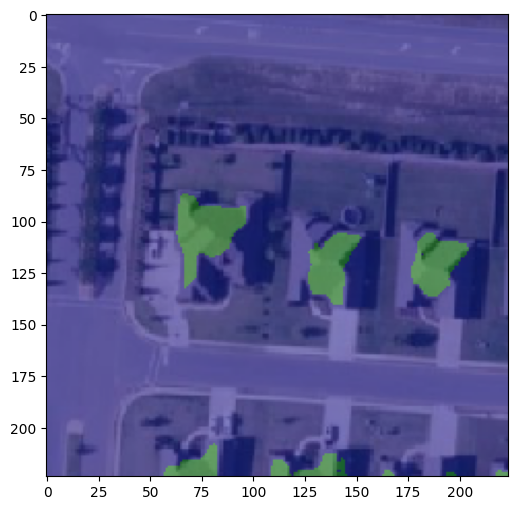

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/iter_6435.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('data/TEST_00000.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [ ]:
type(model)

mmseg.models.segmentors.encoder_decoder.EncoderDecoder

In [ ]:
submit = pd.read_csv("/content/drive/MyDrive/segmentation/sample_submission.csv")


In [ ]:
mask_lst = []
for idx, row in tqdm(submit.iterrows(), total=len(submit["img_id"])):
  img = mmcv.imread(f"data/{row['img_id']}.png")
  result = inference_model(model, img)
  mask = result.pred_sem_seg.data
  mask = mask.detach().cpu().numpy()
  mask = rle_encode(mask)
  if mask == '':
    mask = -1
  mask_lst.append(mask)
submit["mask_rle"] = mask_lst
submit.to_csv("answer.csv", index=False)

  0%|          | 0/60640 [00:00<?, ?it/s]

In [ ]:
!zip -r /content/mask2former.zip /content/mmsegmentation/work_dirs/mask2former

	zip warning: name not matched: /content/mmsegmentation/work_dirs/mask2former

zip error: Nothing to do! (try: zip -r /content/mask2former.zip . -i /content/mmsegmentation/work_dirs/mask2former)


In [ ]:
!unzip /content/drive/MyDrive/segmentation/mask2former.zip -d /content/mmsegmentation/work_dirs

Archive:  /content/drive/MyDrive/segmentation/mask2former.zip
   creating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/
   creating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/20230709_201304/
   creating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/20230709_201304/vis_data/
  inflating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/20230709_201304/vis_data/config.py  
  inflating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/20230709_201304/vis_data/20230709_201304.json  
  inflating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/20230709_201304/vis_data/scalars.json  
  inflating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2former/20230709_201304/20230709_201304.log  
  inflating: /content/mmsegmentation/work_dirs/content/mmsegmentation/work_dirs/mask2fo

In [ ]:
from google.colab import files

files.download('/content/mask2former.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp /content/mask2former.zip /content/drive/MyDrive/segmentation/mask2former.zip

In [ ]:
!cp /content/mmsegmentation/answer.csv /content/drive/MyDrive/segmentation/answer.csv